# main project

#### goal:
Predict review rating (stars) by textual-content using pretrained GLOVE word embeddings+N layers deep LSTM network. Visualize (potencial clusters) on a 2D space using t-SNE.

#### Steps:  
1) Process .text data from yelp review-documents
- filter to leave english-only reviews
- balance the dataset (use similar amount of data for each star rating (1,2,3,4,5*)
- balance the dataset by review length, so the length distribution of reviews for each rating-class is atleast similar (bucketing might be a good idea)

2) Process text for deep-learning
- bring  GLOVE embeddings to a reasonable form
- Tokenize each review 
- transform reviews into tokenized sequences
- Pad sequences to a fixed length
- Prepare the embedding weight-matrix to be used in the Embedding layer (we will not train this layer)
- split into test and train


3) Deep learning
- loss function, regression(rmse) or classification(logloss) big question
- prepare architecture (2-3 LSTM layers -> Dense)
- train, wish for the best

4) Post learning
- extract features from last LSTM layer
- try casting to 2D space using t-SNE


5) Remarks
- we have to limit the amount of data, bc of memory issues possible solution is to save the sequences into HDF and flowing from disk during training


6) 


In [118]:
import pandas as pd
import pandas as pd
import json
import os
import seaborn as sns
import collections
import scipy.sparse as sp
import matplotlib.pyplot as plt
import itertools
import numpy as np
import langdetect
import seaborn
import operator
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import joblib
from sklearn.model_selection import train_test_split

from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Convolution1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
import keras.backend as K
from keras.callbacks import ModelCheckpoint


%matplotlib inline



BASE_DIR = ''
GLOVE_DIR = 'glove.6B.100d.txt'
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = int(''.join([s for s in GLOVE_DIR.split('/')[-1].split('.')[-2] if s.isdigit()])) # 100
VALIDATION_SPLIT = 0.2
PRELOAD = False
# first, build index mapping words in the embeddings set
# to their embedding vector

# print('Indexing word vectors.')

# embeddings_index = {}
# f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
# for line in f:
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     embeddings_index[word] = coefs
# f.close()

In [8]:
#helpers

def minority_balance_dataframe_by_multiple_categorical_variables(df, categorical_columns=None, downsample_by=0.1):
    """
    :param df: pandas.DataFrame
    :param categorical_columns: iterable of categorical columns names contained in {df}
    :return: balanced pandas.DataFrame
    """
    if categorical_columns is None or not all([c in df.columns for c in categorical_columns]):
        raise ValueError('Please provide one or more columns containing categorical variables')

    minority_class_combination_count = df.groupby(categorical_columns).apply(lambda x: x.shape[0]).min()
    
    minority_class_combination_count = int(minority_class_combination_count * downsample_by)
    
    df = df.groupby(categorical_columns).apply(
        lambda x: x.sample(minority_class_combination_count)
    ).drop(categorical_columns, axis=1).reset_index().set_index('level_1')

    df.sort_index(inplace=True)

    return df


def load_glove_into_dict(glove_path):
    """
    loads glove file into a handy python-dict representation, where a word is a key with a corresponding N-dim vector
    http://nlp.stanford.edu/data/glove.6B.zip (pretrained-embeddings)
    """
    embeddings_ix = {}
    with open(glove_path) as glove_file:
        for line in glove_file:
            val = line.split()
            word = val[0]
            vec = np.asarray(val[1:], dtype='float32')
            embeddings_ix[word] = vec
    return embeddings_ix
            

    

def get_features_for_layer(X, trained_model, layer_number):
    """
    :param X: Batch with dimensions according to the models first layer input-shape
    :param trained_model: Model to extract data from
    :param layer_number: Index of the layer we want to extract features from (usually last Conv)
    :return:
    """


    get_features = K.function([trained_model.layers[0].input, K.learning_phase()],
                              [trained_model.layers[layer_number].output])
    
    features = get_features([X, 0])
    
    return features


In [11]:
# 1)

if PRELOAD:
    df_rev_balanced = pd.read_csv('balanced_reviews.csv')
else:
    df_reviews = pd.read_csv('reviews.csv')#, encoding='utf-8')
    df_reviews['len'] = df_reviews.text.str.len()
    df_reviews = df_reviews[df_reviews['len'].between(10, 4000)]
#     df_reviews = df_reviews[df_reviews.language == 'en']
    # balancing dataset
    df_rev_balanced = minority_balance_dataframe_by_multiple_categorical_variables(
        df_reviews, categorical_columns=['stars'], downsample_by=0.1
    )
    
    df_rev_balanced.to_csv('balanced_reviews.csv', encoding='utf-8')

df_rev_balanced.shape

(171960, 7)

stars
1.0    Axes(0.125,0.125;0.775x0.775)
2.0    Axes(0.125,0.125;0.775x0.775)
3.0    Axes(0.125,0.125;0.775x0.775)
4.0    Axes(0.125,0.125;0.775x0.775)
5.0    Axes(0.125,0.125;0.775x0.775)
Name: len, dtype: object

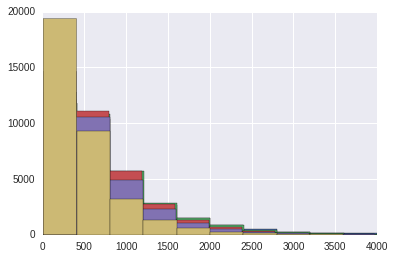

In [10]:
#inspect review length for each star-group
# df_rev_balanced['len'] = df_reviews.text.str.len()
df_rev_balanced.groupby('stars')['len'].hist(alpha=0.1)

In [12]:
embeddings_index = load_glove_into_dict(GLOVE_DIR)

In [13]:
print('number of words in GLOVE: {}'.format(len(embeddings_index)))

number of words in GLOVE: 400000


In [15]:
#tokenization 

if PRELOAD:
    tokenizer = joblib.load('tokenizer.pickle')
else:
    tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(df_rev_balanced.text.tolist())
    joblib.dump(tokenizer, 'tokenizer.pickler')

WORD_INDEX_SORTED = sorted(tokenizer.word_index.items(), key=operator.itemgetter(1))

In [18]:
WORD_INDEX_SORTED[:10]

[('the', 1),
 ('and', 2),
 ('i', 3),
 ('a', 4),
 ('to', 5),
 ('was', 6),
 ('of', 7),
 ('it', 8),
 ('for', 9),
 ('in', 10)]

In [58]:
embedding matrix

# prepare embedding matrix
nb_words = min(MAX_NB_WORDS, len(WORD_INDEX_SORTED))
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


(20000, 100)

In [82]:
# seqs = tokenizer.texts_to_sequences(df_rev_balanced.text.values)
X = pad_sequences(seqs, maxlen=MAX_SEQUENCE_LENGTH)
Y = df_rev_balanced.stars.values.astype(int)
Y_cat = to_categorical(Y)
assert X.shape[0] == Y.shape[0]

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.2)

In [ ]:
filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]



model = Sequential()

model.add(Embedding(input_dim=nb_words, 
                    output_dim=EMBEDDING_DIM, 
                    input_length=MAX_SEQUENCE_LENGTH, 
                    weights=[embedding_matrix], 
                    trainable=False)
         )
# model.add(Convolution1D(nb_filter=128, filter_length=5, border_mode='same', activation='relu'))
# model.add(MaxPooling1D(pool_length=2))
model.add(GRU(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(100))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, 
          y_train, 
          nb_epoch=40, 
          batch_size=256, 
          validation_data=(X_test, y_test),
          callbacks=callbacks_list
)
# Final evaluation of the model
# scores = model.evaluate(x_test, y_test, verbose=0)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_23 (Embedding)         (None, 1000, 100)     0           embedding_input_23[0][0]         
____________________________________________________________________________________________________
gru_14 (GRU)                     (None, 1000, 100)     60300       embedding_23[0][0]               
____________________________________________________________________________________________________
dropout_12 (Dropout)             (None, 1000, 100)     0           gru_14[0][0]                     
____________________________________________________________________________________________________
gru_15 (GRU)                     (None, 100)           60300       dropout_12[0][0]                 
___________________________________________________________________________________________

In [98]:
model.predict(X_test[:10]).argmax(axis=1)

array([1, 4, 1, 5, 2, 5, 2, 4, 5, 2])

In [104]:
y_test[:10].argmax(axis=1)

array([1, 5, 1, 3, 2, 5, 4, 5, 5, 3])

(10, 100)